# Sentiment analysis

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
#from livelossplot import PlotLossesKeras
np.random.seed(7)
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LSTM
from keras.layers.embeddings import Embedding
from keras.utils import np_utils
from keras.preprocessing import sequence
from gensim.models import Word2Vec, KeyedVectors, word2vec
import gensim
from gensim.utils import simple_preprocess
from keras.utils import to_categorical
import pickle
import h5py
from time import time

In [31]:
filename = 'data/Dataset.csv'
dataset = pd.read_csv(filename, delimiter = ",")
dataset=dataset.head(1000)


In [32]:
dataset.head()

,description,length,rate
0,Polecam nie pierwszy i nie ostatni raz!,39.0,1.0
1,Bardzo dobra komunikacja sms i telefoniczna. Z...,121.0,1.0
2,Polecam zakupy w tym sklepie. Są dostępne częś...,87.0,1.0
3,0,0.0,0.0
4,Jestem w pełni zadowolona z przebiegu transakcji,48.0,1.0


In [33]:
# Delete unused column
del dataset['length']


In [34]:
# Delete All NaN values from columns=['description','rate']
dataset = dataset[dataset['description'].notnull() ]


In [35]:
dataset = dataset[dataset['rate'].notnull() ]


In [36]:
 # Set all strings as lower case letters
dataset['description'] = dataset['description'].str.lower()

In [37]:
X = dataset['description']
y = dataset['rate']

#split to train, test and validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [38]:
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('nkjp.txt', binary=False)

embedding_matrix = word2vec_model.wv.syn0
print('Shape of embedding matrix: ', embedding_matrix.shape)

Shape of embedding matrix:  (2123132, 100)


D:\Anaconda3\Lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Anaconda3\Lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [89]:
top_words = embedding_matrix.shape[0]
mxlen = 50
nb_classes = 3
 
tokenizer = Tokenizer(num_words=top_words)
tokenizer.fit_on_texts(X_train)
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)
 
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
print(word_index)
 
X_train = sequence.pad_sequences(sequences_train, maxlen=mxlen)
X_test = sequence.pad_sequences(sequences_test, maxlen=mxlen)
X_val = sequence.pad_sequences(sequences_val, maxlen=mxlen)
 
y_train = np_utils.to_categorical(y_train, nb_classes)
y_test = np_utils.to_categorical(y_test, nb_classes)
y_val = np_utils.to_categorical(y_val, nb_classes)

AttributeError: 'numpy.ndarray' object has no attribute 'lower'

In [40]:

batch_size = 16
nb_epoch = 4

embedding_layer = Embedding(embedding_matrix.shape[0],
                            embedding_matrix.shape[1],
                            weights=[embedding_matrix],
                            trainable=False)

model = Sequential()
model.add(embedding_layer)
model.add(LSTM(128, recurrent_dropout=0.5, dropout=0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 100)         212313200 
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 387       
_________________________________________________________________
activation_4 (Activation)    (None, 3)                 0         
Total params: 212,430,835
Trainable params: 117,635
Non-trainable params: 212,313,200
_________________________________________________________________


In [41]:

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
rnn = model.fit(X_train, y_train, nb_epoch= nb_epoch, batch_size=batch_size, shuffle=True, validation_data=(X_val, y_val))
score = model.evaluate(X_val, y_val)
print("Test Loss: %.2f%%" % (score[0]*100))
print("Test Accuracy: %.2f%%" % (score[1]*100))


D:\Anaconda3\Lib\site-packages\ipykernel_launcher.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  This is separate from the ipykernel package so we can avoid doing imports until


Train on 640 samples, validate on 160 samples
Epoch 1/4
640/640 [==============================] - 4s 6ms/step - loss: 0.2451 - acc: 0.9328 - val_loss: 0.0813 - val_acc: 0.9812
Epoch 2/4
640/640 [==============================] - 2s 4ms/step - loss: 0.0426 - acc: 0.9813 - val_loss: 0.0059 - val_acc: 1.0000
Epoch 3/4
640/640 [==============================] - 2s 4ms/step - loss: 0.0181 - acc: 0.9969 - val_loss: 0.0018 - val_acc: 1.0000
Epoch 4/4
160/160 [==============================] - 0s 406us/step
Test Loss: 0.08%
Test Accuracy: 100.00%


In [42]:

print('Save model...')
model.save('Models/finalsentimentmodel.h5')
print('Saved model to disk...')

print('Save Word index...')
output = open('Models/finalwordindex.pkl', 'wb')
pickle.dump(word_index, output)
print('Saved word index to disk...')


Save model...
Saved model to disk...
Save Word index...
Saved word index to disk...


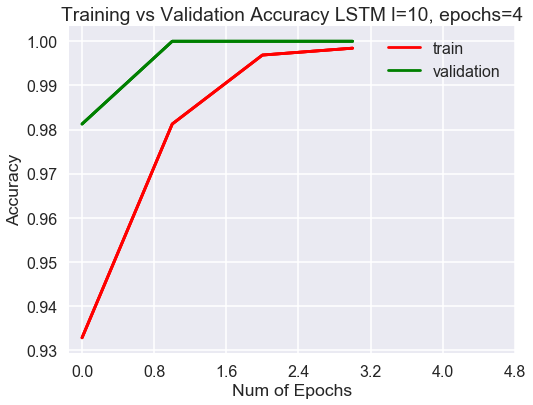

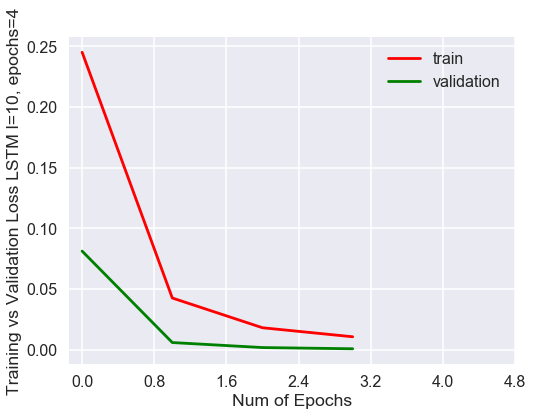

In [94]:


plt.figure(0)
plt.plot(rnn.history['acc'],'r')
plt.plot(rnn.history['val_acc'],'g')
plt.xticks(np.arange(0, nb_epoch+1, nb_epoch/5))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy LSTM l=10, epochs=4") # for max length = 10 and 20 epochs
plt.legend(['train', 'validation'])

plt.figure(1)
plt.plot(rnn.history['loss'],'r')
plt.plot(rnn.history['val_loss'],'g')
plt.xticks(np.arange(0, nb_epoch+1, nb_epoch/5))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Training vs Validation Loss LSTM l=10, epochs=4") # for max length = 10 and 20 epochs
plt.legend(['train', 'validation'])
plt.show()


In [96]:

# Apply Precision-Recall

from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

y_pred = model.predict(X_test)

# Convert Y_Test into 1D array
yy_true = [np.argmax(i) for i in y_test]
print('yy_true')
print(yy_true)

yy_scores = [np.argmax(i) for i in y_pred]
print('yy_scores')
print(yy_scores)

print("Recall: " + str(recall_score(yy_true, yy_scores, average='weighted')))
print("Precision: " + str(precision_score(yy_true, yy_scores, average='weighted')))
print("F1 Score: " + str(f1_score(yy_true, yy_scores, average='weighted')))


yy_true
[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]
yy_scores
[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [97]:
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = model.predict(X_test, verbose=2)
y_pred = np.argmax(Y_pred, axis=1)



In [98]:
Y_pred

array([[1.54072506e-04, 9.99826849e-01, 1.90515875e-05],
       [2.23652154e-04, 9.99710858e-01, 6.54711548e-05],
       [9.89037944e-05, 9.99878049e-01, 2.30293008e-05],
       [2.53048202e-04, 9.99715149e-01, 3.17872255e-05],
       [9.88388479e-01, 1.12399319e-02, 3.71606759e-04],
       [7.56224443e-04, 9.99185979e-01, 5.78068830e-05],
       [2.00969153e-04, 9.99773562e-01, 2.54702481e-05],
       [3.62777908e-04, 9.99587953e-01, 4.92964245e-05],
       [5.70780947e-04, 9.99378681e-01, 5.05351709e-05],
       [6.75519463e-04, 9.99279082e-01, 4.53375724e-05],
       [2.44240800e-04, 9.99713123e-01, 4.26899860e-05],
       [9.88388479e-01, 1.12399319e-02, 3.71606759e-04],
       [1.88405247e-04, 9.99788702e-01, 2.28509834e-05],
       [6.46137458e-04, 9.99326825e-01, 2.70556811e-05],
       [2.90267199e-04, 9.99631882e-01, 7.77666573e-05],
       [7.07474028e-05, 9.99900699e-01, 2.85115711e-05],
       [7.56615918e-05, 9.99916792e-01, 7.56013242e-06],
       [2.05251781e-04, 9.99744

In [65]:
for ix in range(2):
    print(ix, confusion_matrix(np.argmax(y_test, axis=1), y_pred)[ix].sum())
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
print(cm)
 

0 3
1 197
[[  3   0]
 [  0 197]]


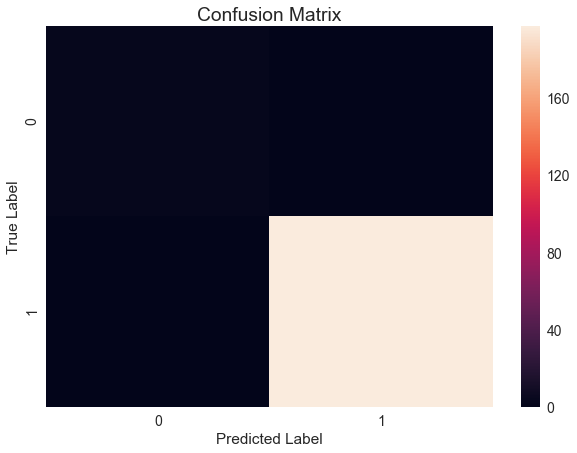

In [72]:
# Visualizing of confusion matrix
import seaborn as sn
 
#df_cm = pd.DataFrame(cm, range(2), range(2))
df_cm = pd.DataFrame(cm, range(2))
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=False)
sn.set_context("poster")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
#plt.savefig('Plots/confusionMatrix.png')
plt.show()

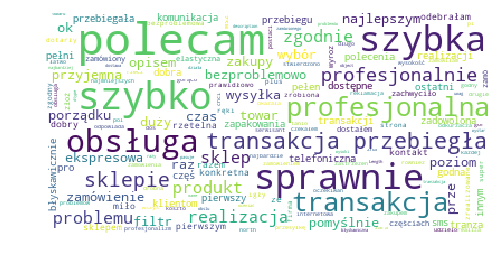

In [82]:

from wordcloud import WordCloud
from many_stop_words import get_stop_words
 
stop_words = get_stop_words('pl')
 
wordcloud = WordCloud(
                    background_color='white',
                    stopwords=stop_words,
                    max_words=200,
                    max_font_size=40,
                    random_state=42
).generate(str(dataset['description']))
 
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [99]:
# ROC Curve

from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

# Compute ROC curve and ROC area for each class

n_classes = 2
lw = 2
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(np.array(pd.get_dummies(yy_true))[:, i], np.array(pd.get_dummies(yy_scores))[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [100]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(np.array(pd.get_dummies(yy_true))[:, i], np.array(pd.get_dummies(yy_scores))[:, i])
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

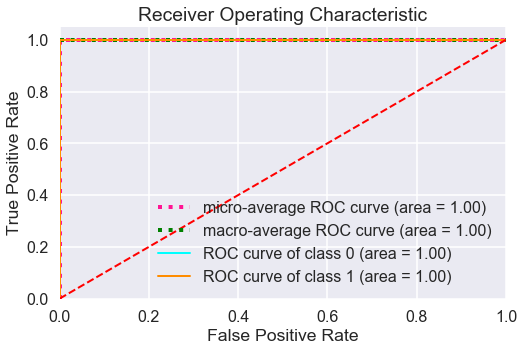

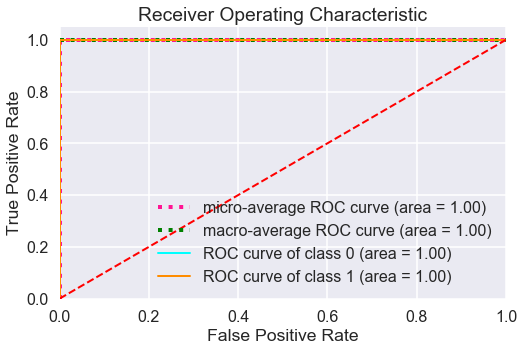

In [88]:
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(8,5))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='green', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--',color='red', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
#plt.savefig('Plots/ROCcurve.png')
plt.show()